Title: PCA
Author: Thomas Breuel
Institution: UniKL

In [1]:
from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom

In [2]:
def showgrid(images,rows=None,cols=10,size=1,cmap=cm.gray):
    if rows is None: rows = (len(images)+cols-1)//cols
    figsize(cols*size,rows*size)
    for i in range(len(images)):
        subplot(rows,cols,i+1)
        imshow(images[i],cmap=cmap)

# The MNIST Database

In [3]:
# loading the MNIST database
with tables.openFile("mnist.h5","r") as mnist:
    print mnist
    images = array(mnist.root.deskewed,'f')
    labels = array(mnist.root.labels,'i')
    test_images = array(mnist.root.test_deskewed,'f')
    test_labels = array(mnist.root.test_labels,'i')

mnist.h5 (File) ''
Last modif.: 'Tue Jun  5 10:16:56 2012'
Object Tree: 
/ (RootGroup) ''
/deskewed (EArray(60000, 28, 28), shuffle, zlib(9)) ''
/images (CArray(60000, 28, 28), shuffle, zlib(9)) ''
/labels (CArray(60000,), shuffle, zlib(9)) ''
/test_deskewed (EArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_images (CArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_labels (CArray(10000,), shuffle, zlib(9)) ''



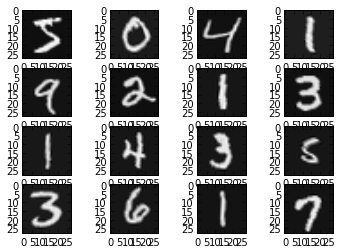

In [6]:
# characters from the (deskewed) MNIST database
for i in range(16):
    subplot(4,4,i+1)
    imshow(images[i])

Eigenvector Computation
=========================

Let's start by looking at what the "average" character looks like:



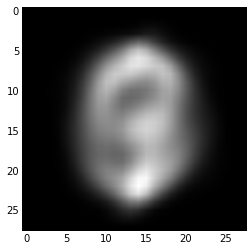

In [4]:
mu = mean(images,axis=0)
gray()
imshow(mu)

If you think of each character image as a vector in a high dimensional space, the characters form a cloud of points in that space.

That cloud is not in general centered at the origin. Let us center it at the origin.



In [11]:
centered = images - mu[newaxis,:,:]

In terms of images, this has an odd looking effect.



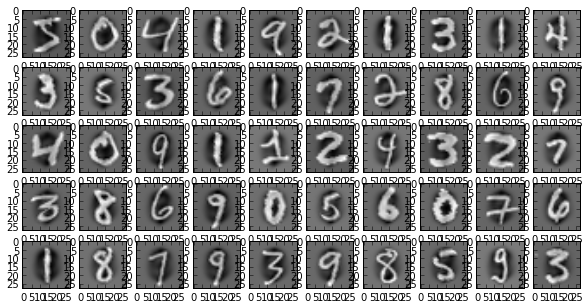

In [12]:
showgrid(centered[:50])

# Image Covariances

We're treating images as data vectors.

Our images are stored in rank 3 arrays `centered[N,height,width]`.

To treat these as data vectors for machine learning, we need to reshape this into `data[N,height*width]`



In [13]:
def make2d(a): 
    """Make an array of images into an array of data vectors."""
    return a.reshape(len(a),prod(a.shape[1:]))

Let's look at the covariance matrix of this data now.

This tells us how much each pixel "co-varies" with any other pixel.



In [14]:
covariance = dot(make2d(centered).T,make2d(centered))/len(centered)
print covariance.shape,amin(covariance),amax(covariance)

(784, 784) -0.114308 0.208461


Let's look at the entire covariance matrix. Here, green is zero, red is high, and blue is low.

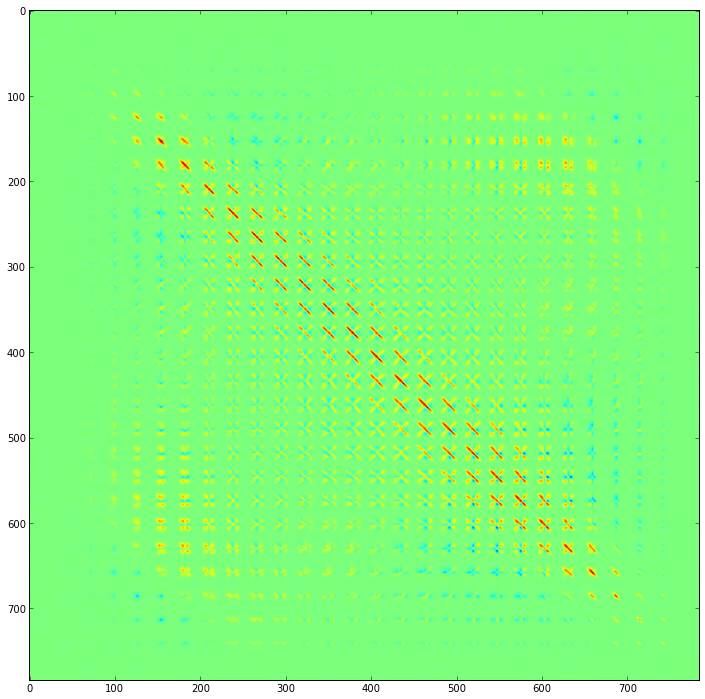

In [15]:
figsize(12,12)
imshow(covariance,cmap=cm.jet,vmin=-0.2,vmax=0.2)

The diagonal of this matrix is just the variances of each pixel. We can transform these back into a 2D image. Necessarily, these are all positive.

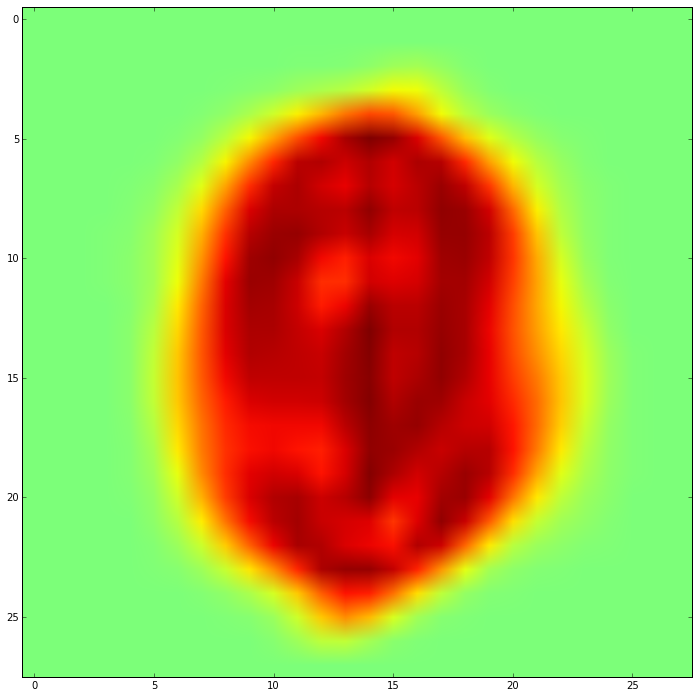

In [17]:
d = covariance[arange(784),arange(784)]
imshow(d.reshape(28,28),cmap=cm.jet,vmin=-0.2,vmax=0.2)

We can also look at the covariance of pixels with the pixel at (14,14). We see that pixels above and below that pixel are likely to be on when it's on, while pixels to the left and right are likely to be off when it's on. We get an entirely different picture when looking at the pixel at (14,20). Nearby pixels have similar covariances.



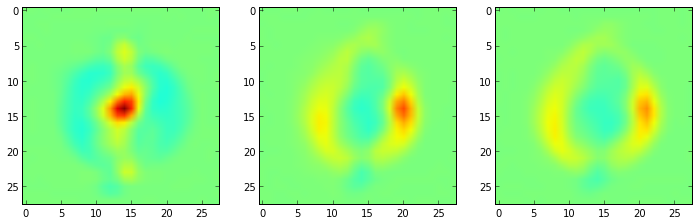

In [21]:
d = covariance[14+14*28,:]; subplot(131); imshow(d.reshape(28,28),cmap=cm.jet,vmin=-0.2,vmax=0.2)
d = covariance[20+14*28,:]; subplot(132); imshow(d.reshape(28,28),cmap=cm.jet,vmin=-0.2,vmax=0.2)
d = covariance[21+14*28,:]; subplot(133); imshow(d.reshape(28,28),cmap=cm.jet,vmin=-0.2,vmax=0.2)

# Eigenvector Computations

Returning to the view of images as data vectors in a high dimensional space, we can ask the question: what is the major direction of variation of these data vectors? This question is answered by computing the eigenvectors of the covariance matrix.



In [23]:
evals,evecs = linalg.eig(covariance)
top = argsort(-evals)
evals = evals[top]
evecs = evecs.T[top] # NB: eigenvectors come out backwards
print evals.shape,evecs.shape

(784,) (784, 784)


Let's look at these eigenvectors.



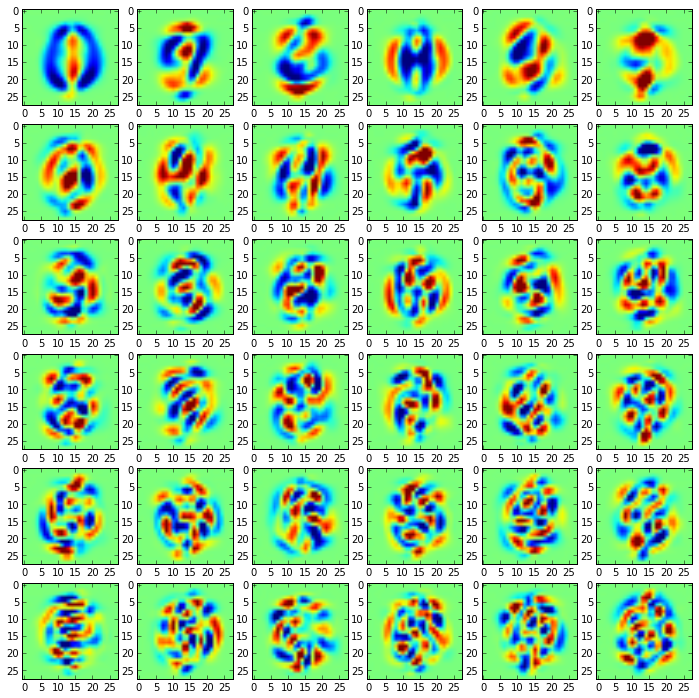

In [24]:
figsize(12,12)
for i in range(36):
    subplot(6,6,i+1)
    imshow(real(evecs[i]).reshape(28,28),vmin=-0.1,vmax=+0.1,cmap=cm.jet)

Let's look at the corresponding eigenvalues.



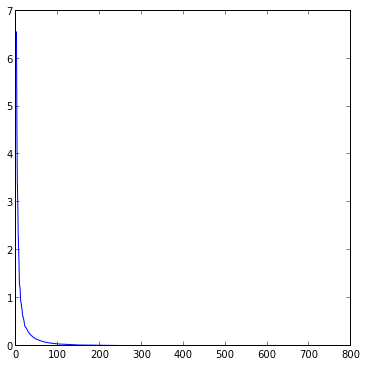

In [44]:
figsize(6,6)
plot(sorted(evals,reverse=1))

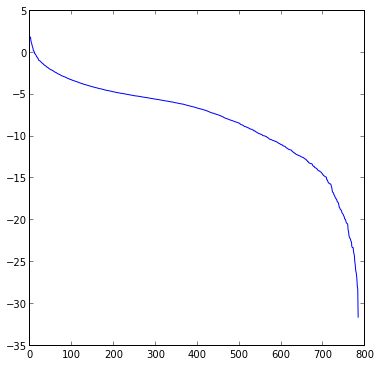

In [43]:
figsize(6,6)
plot(sorted(log(evals),reverse=1))

# Interpretation of Eigenvectors and Eigenvalues

Why do we perform these odd eigenvalue computations?

Assume that we have a diagonal matrix 

$$ D = \left( \begin{array}{ccc}
a & 0 & 0 \\\\
0 & b & 0 \\\\
0 & 0 & c \end{array} \right) $$

What are its eigenvectors and eigenvalues?

Simple: the eigenvectors are the Euclidean basis vectors, and the corresponding eigenvalues are the diagonal elements of the matrix $D$:

$$ \left( \begin{array}{ccc}a & 0 & 0 \\\\0 & b & 0 \\\\0 & 0 & c \end{array} \right) \cdot 
\left(\begin{array}{c}1\\\\0\\\\0\end{array}\right) = a \left(\begin{array}{c}1\\\\0\\\\0\end{array}\right)$$

or

$$ D \cdot e_1 = a ~ e_1 $$



Now assume that we rotate the coordinate system with a rotation $R$.

The matrix $D$ becomes $M = R D R^T$, and the vectors $e_1$ becomes $v = R e_1$. Then:

$$ R D R^T \cdot R e_1 = a ~ R e_1 $$

or

$$ M \cdot v = a v $$

We see:

- the normalized eigenvectors form a basis for a rotated coordinate system
- in that coordinate system, each eigenvector is a Euclidean basis vector

There's a second important point to the interpretation of these matrices.

Consider a multidimensional Gaussian density: 

$$ p(x) = \frac{1}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({\mathbf x}-{\boldsymbol\mu})^T{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})
\right) $$

Now assume $\mu=0$ and $\Sigma = \hbox{diag}(\sigma_1,...,\sigma_d)$.

$$p(x) \propto \exp\left( -\frac{1}{2} {\mathbf x}^T\Sigma^{-1}{\mathbf x} \right) = \exp(\sum r_i \sigma_i^-1)$$

We can get an idea of the shape of this distribution by looking at $p(x) = \hbox{const}$:

$$p(x) = \hbox{const} \Leftrightarrow \sum \frac{x_i^2}{\sigma_i} = \hbox{const} $$

But this is just the equation of an ellipse; in 2D:

$$\frac{x^2}{a}+\frac{y^2}{b} = 1$$


(summary PCA intepretation)

- PCA finds a rotation of space that diagonalizes the covariance matrix
- the diagonal elements in this rotated coordinate system give us the distribution of the data along the corresponding axis

Projection and Reconstruction
=============================

PCA allows us to "compress" data. In particular, on average, if we leave out some direction given by an eigenvector, we lose as much variance as was contributed by that eigenvectors. The best vectors to leave out (for data compression) are those with the smallest variance.



In [25]:
ys = dot(make2d(evecs[:20]),make2d(centered).T).T
print ys.shape

(60000, 20)


Now we only have 20 numbers (instead of 784) stored per digit. What does the reconstruction look like?



In [26]:
reconstructed = dot(ys,make2d(evecs[:20])) + mu.ravel()[newaxis,:]
reconstructed.shape = (60000,28,28)

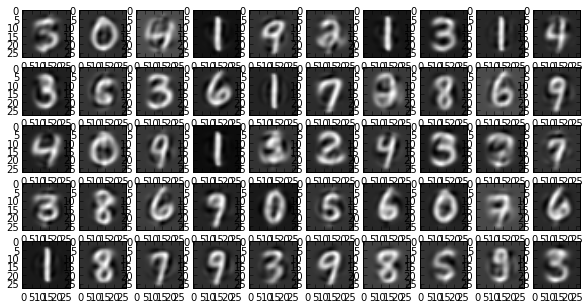

In [27]:
showgrid(reconstructed[:50])

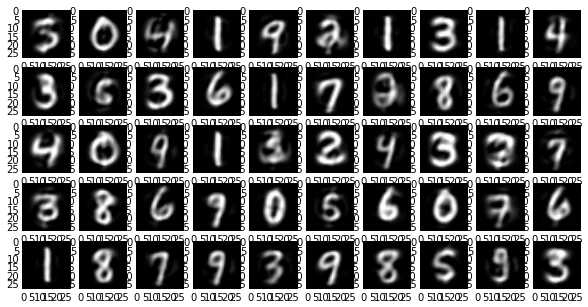

In [28]:
showgrid(clip(reconstructed[:50],0,1))

(60000, 100)


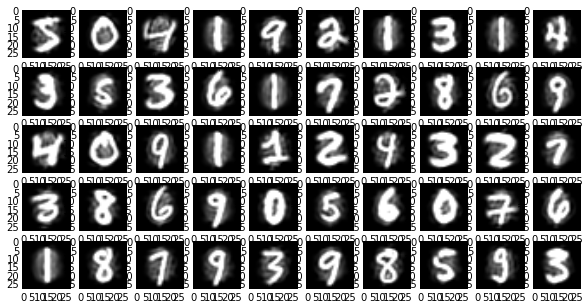

In [29]:
ys = dot(make2d(evecs[:100]),make2d(images).T).T
print ys.shape
reconstructed = dot(ys,make2d(evecs[:100])) + mu.ravel()[newaxis,:]
reconstructed.shape = (60000,28,28)
showgrid(clip(reconstructed[:50],0,1))

Note the best approximation property: if we use the eigenvectors corresponding to the largest
eigenvalues, then we get the best linear approximation of the inputs for that many inputs.

Why? Again, think about this in diagonalized space.

Classifiers after PCA
=====================

Many classifiers are invariant under isometric linear transformations of the input
and/or just have a linear transformation right at the input.  Among these are:

- nearest neighbor
- MLPs
- support vector machines

Performing PCA speeds them up greatly, and, as long as the PCA reconstruction is
close to the original, doesn't change the performance.

Some degree of "throwing away" data by PCA can actually improve classifier performance
by removing noise (which usually shows up in small PCA components).

In [17]:
def nneval(training,ltraining,testing,ltesting,metric='euclidean',p=2):
    ds = distance.cdist(make2d(testing),make2d(training),metric=metric,p=p)
    closest = argmin(ds,axis=1)
    predictions = [ltraining[i] for i in closest]
    errors = sum(array(predictions)!=array(ltesting))
    return errors*1.0/len(testing)

In [18]:
def proj(images,n):
    return dot(make2d(evecs[:n]),make2d(images).T).T

In [23]:
nneval(proj(centered,20)[:1000],labels[:1000],proj(test_images-mu[newaxis,:],20),test_labels)

0.083000000000000004

In [24]:
for k in [5,10,20,50,100,200,500]:
    print k,nneval(proj(centered,k)[:1000],labels[:1000],proj(test_images-mu[newaxis,:],k),test_labels)

5 0.2414
10 0.1359
20 0.083
50 0.0712
100 0.0757
200 0.0753
500 0.0762

# Stepwise PCA Computation

There is another way we can compute PCA based on a simple
eigenvector computation.

For a matrix $M$, the eigenvector with the largest eigenvalue
is easy to find as

$v_0 = \lim_{k\rightarrow\infty} \frac{M^k v}{||M^k v||}$


for any starting vector $v$ that is not orthogonal to the
eigenvector (a random starting vector rarely is).



Why does this work?  You can figure this out just by 
looking at a diagonal matrix:

$M = \begin{pmatrix}e_0 & 0 & ... & 0 \\\\ 0 & e_1 & ... & 0 \\\\ ... & ... & ... & ...\\\\ 0 & 0 & ... & e_n \end{pmatrix} $

You get $M^k$ by exonentiating each diagonal element.
If $e_0$ is the largest element, then
for sufficiently large $k$, $e_0^k >> e_i^k$ for $k\neq0$.
As a result, only the entry of $v$ corresponding to $e_0$ will
"survive" for large enough $k$.

Usually, we perform this computation incrementally.

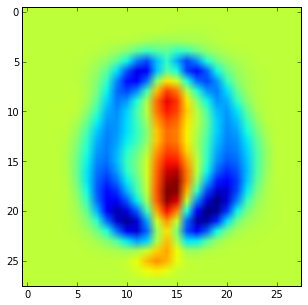

In [30]:
v = randn(28*28)
for i in range(1000):
    v = dot(covariance,v)
    v /= norm(v)
imshow(v.reshape(28,28),cmap=cm.jet)

If we want more than one eigenvector, we could simply subtract $v_0$ from
all the input vectors and repeat the computation.  However, that is
kind of slow.

Instead, we can update the covariance matrix and remove the entire
subspace corresponding to $v_0$.

In [32]:
evs = []
cov1 = covariance.copy()
for j in range(10):
    sys.stderr.write("%d "%j)
    v = randn(cov1[0].size)
    for i in range(1000):
        v = dot(cov1,v)
        v /= norm(v)
    evs.append(v)
    l = dot(covariance.ravel(),outer(v,v).ravel())
    cov1 -= l*outer(v,v)

0 1 2 3 4 5 6 7 8 9 

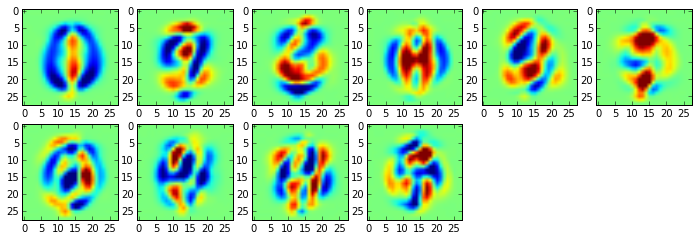

In [33]:
evs = [v.reshape(28,28) for v in evs]
figsize(12,12)
for i in range(10):
    subplot(6,6,i+1)
    imshow(real(evs[i]).reshape(28,28),vmin=-0.1,vmax=+0.1,cmap=cm.jet)

# "Neural" PCA Algorithm

This algorithm can be converted into a fully incremental algorithm that does not even
require the covariance matrix to be stored, but only the eigenvector candidates.

The key idea for that is that (for input vectors $x_i$):

$M = \sum x_i^T x_i$

And (without normalization):

$v_0 \leftarrow M \cdot v_0$

Replacing that

$v_0 \leftarrow (\sum x_i^T x_i) \cdot v_0 $

$v_0 \leftarrow (\sum x_i^T x_i) \cdot v_0 $

But if we don't have the sum, we can just do small updates and hope things will average out in the long run:

$v_0 \leftarrow v_0 + \eta (x_i^T x_i) \cdot v_0 $

Furthermore, we can update $v_1$ in a similar way by removing
any component that points in the direction of the current $v_0$:

$ x_0^{(1)} = x_0 - (v_0\cdot x_0) v_0 $

$ v_1 \leftarrow v_1 + \eta (x_i^{(1) T} x_i^{(1)}) \cdot v_0 $

Fully implemented, this gives a "neural network" that allows us to compute the top $k$ eigenvector
(PCA components) without any storage of the covariance matrix.

Algorithms are often considered "neural network algorithms" if they

- can be implemented in terms of a low-depth circuit
- do not require storage of the full dataset or the full covariance matrix

In [35]:
# randomly initialized eigenvectors
d = 28*28
evs = array([randn(d) for i in range(6)])
evs = array([e/norm(e) for e in evs])

In [36]:
# incremental updates
eta = 0.001
def update(x):
    x = x/norm(x)
    for i,e in enumerate(evs):
        # update e_i
        e += eta*x*dot(x,e)
        # normalize e_i
        e /= norm(e)
        # remove e_i from the vector x
        x -= dot(e,x)*e

In [37]:
# running the incremental algorithm
for iter in range(1000000):
    if iter%100000==0: print iter
    update(centered[iter%len(centered)].ravel())

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


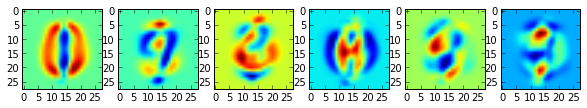

In [38]:
# final outputs
figsize(10,10)
for i in range(6):
    subplot(1,6,i+1)
    imshow(evs[i].reshape(28,28),cmap=cm.jet)